In [1]:
import re
import collections
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)

In [2]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)

In [3]:
def find_natasha(text):
    '''Функция, которая находит организации и адреса в статье'''
    # создадим множества организация и адресов, чтобы они не повторялись
    orgs = set()
    locs = set()
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)
    for word in doc.spans:
        word.tokens[-1].lemmatize(morph_vocab)
        # Если организация, то добавляем к множеству организаций
        if word.type == 'ORG':
            orgs.add(word.tokens[-1].lemma)
        # Если адрес, то добавляем к множеству адресов
        elif word.type == 'LOC':
            locs.add(word.tokens[-1].lemma)
    return orgs, locs

In [4]:
def take_article(filename):
    '''Функция, которая достает статьи из файла'''
    with open(filename, encoding='utf-8') as file:
        text = file.read()
        articles = re.findall('-\n(.+\n.+)\n=', text)
        return articles

In [5]:
def get_org(articles):
    '''Функция, которая строит граф связей организаций и адресов'''
    # Граф будет в виде {Организация: {Адрес: количество общих статей}}
    organizations = collections.defaultdict(lambda: collections.defaultdict(int))
    for article in articles:
        orgs, locs = find_natasha(article)
        for org in orgs:
            for loc in locs:
                organizations[org][loc] += 1
    return organizations

In [21]:
def find_adress(organizations):
    '''Функция выбирает наиболее вероятный адрес каждой организации'''
    new_connects = {}
    for org in organizations:
        m = 0
        m_loc = False
        for loc in organizations[org]:
            # выбираем тот адрес, который чаще всего встречается с данной организацией и при этом не менее 5 раз
            if organizations[org][loc] > m and organizations[org][loc] > 5:
                m = organizations[org][loc]
                m_loc = loc
        if m_loc:
            # оздаем словарь, в котором каждому значению организации соответствует ее наиболее вероятный адрес
            # и количесвто общих статей
            new_connects[org] = {m_loc: m}
    return new_connects

In [22]:
articles = take_article('news.txt')
connects = get_org(articles)
organizations = find_adress(connects)
print(organizations)

{'2': {'александрия': 19}, 'минобразование': {'ставрополье': 9}, 'ск': {'район': 241}, 'мир': {'район': 24}, 'пфр': {'россия': 15}, 'банк': {'россия': 6}, 'мфц': {'ставрополье': 16}, 'ставропольский': {'район': 22}, 'культура': {'район': 90}, '»': {'район': 235}, 'гуп': {'район': 13}, 'бв': {'благодарный': 69}, 'благодарненский': {'благодарный': 20}, 'апк': {'район': 23}, 'досуг': {'округ': 20}, 'covid-19': {'ставрополье': 17}, 'досааф': {'россия': 30}, 'роспотребнадзор': {'ставрополье': 33}, 'сила': {'россия': 52}, 'магнит': {'район': 9}, 'минздрав': {'ставрополье': 33}, 'россия': {'россия': 47}, 'центр': {'благодарный': 23}, 'совет': {'район': 33}, 'гибдд': {'россия': 24}, 'кмв': {'ставрополье': 10}, 'бго': {'округ': 92}, 'сбербанк': {'район': 8}, 'образование': {'округ': 27}, '1': {'благодарный': 51}, 'больница': {'ставрополье': 23}, 'каменнобалковское': {'район': 6}, 'мчс': {'ставрополье': 18}, 'скр': {'ставрополье': 7}, 'молодежь': {'район': 31}, 'су': {'район': 6}, 'фонд': {'став

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np

In [24]:
# Определим функцию отрисовки графа.
def formASocialGraph(organizations):
    # Добавляем дуги в граф. Вершины добавятся из названий дуг.
    G=nx.Graph()
    # Перебираем все найденные персоны.
    for n in organizations.keys():
        for n2 in organizations[n].keys():
            # Собственно, добавляем дугу к графу. Вершины добавятся сами.
            G.add_edge(n, n2)
    return G

In [25]:
G1=formASocialGraph(organizations)

In [38]:
def drawASocialGraph(G, orgs, colors='b', layout='spring'):
    # Строим расположение вершин графа на плоскости.
    if layout=='kawai':
        pstn=nx.kamada_kawai_layout(G)
    elif layout=='circle':
        pstn=nx.drawing.layout.circular_layout(G2)
    elif layout=='random':
        pstn=nx.drawing.layout.random_layout(G2)
    else:
        pstn=nx.spring_layout(G)
    # Размер вершины зависит от частоты упоминания.
    # sz=[freqs[n] for n in G.nodes]
    # Толщина линии дуги зависит от логарифма частоты совместной встречаемости участников новости.
    # lw=[math.log(orgs[e[0]][e[1]], 10)+1 for e in G.edges]
    # Рисуем граф.
    nx.draw(G, pos=pstn, node_color=colors, edge_color='g', with_labels=True);

<IPython.core.display.Javascript object>


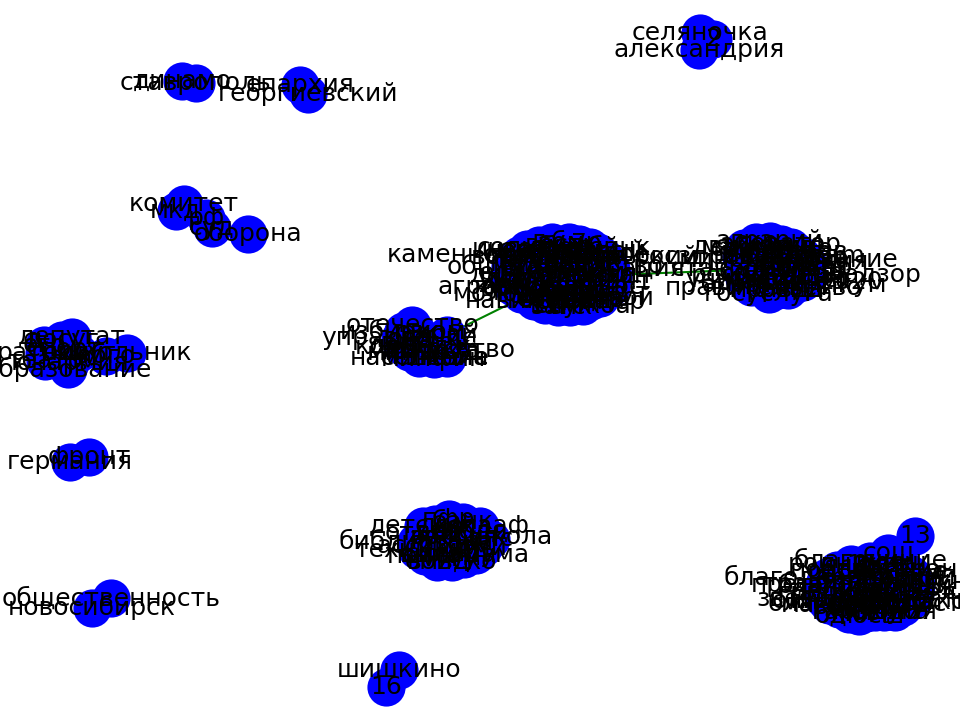

In [39]:
drawASocialGraph(G1, organizations)